# MSADS509 M6 UE Wang

# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here

import os.path
from dateutil import parser
import shutil

import glob

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/UE/Desktop/M1 Results"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "/Users/UE/Desktop/M1 Results/positive-words.txt"
negative_words_file = "/Users/UE/Desktop/M1 Results/negative-words.txt"
tidy_text_file = "/Users/UE/Desktop/M1 Results/tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# lyrics data

lyrics_data = {}

lyrics_path = os.path.join(data_location, lyrics_folder)

rows = []

for artist_folder in os.listdir(lyrics_path):
    artist_folder_path = os.path.join(lyrics_path, artist_folder)

    if os.path.isdir(artist_folder_path):
        file_paths = glob.glob(os.path.join(artist_folder_path, '*.txt'))

        for file_path in file_paths:
            with open(file_path, 'r') as file:
                lyrics_content = file.read()

            song_end_index = lyrics_content.find('"', 1) 
            song_name = lyrics_content[1:song_end_index]
            lyrics_content = lyrics_content[song_end_index + 1:].strip() 

            rows.append((artist_folder, song_name, lyrics_content))

lyrics_data = pd.DataFrame(rows, columns=['artist', 'song', 'lyrics'])
lyrics_data

,artist,song,lyrics
0,robyn,Include Me Out,"It is really very simple\nJust a single pulse,..."
1,robyn,Electric,Electric...\n\nIt's electric\nIt's a natural h...
2,robyn,Beach 2K20,(So you wanna go out?\nHow you gonna get there...
3,robyn,Love Kills,If you're looking for love\nGet a heart made o...
4,robyn,Time Machine,"Hey, what did I do?\nCan't believe the fit I j..."
...,...,...,...
415,cher,Take It From The Boys,So scared I never been\nToo hard to keep it in...
416,cher,Dream Baby,I found the boy for me\nHe's my dream baby\n\n...
417,cher,Please Don't Tell Me,Ya shook the override \nWhy'd I get this far t...
418,cher,I Hope You Find It,"These clouds aren't going nowhere, darling\nRa..."


In [5]:
# twitter data

twitter_files = os.path.join(data_location, twitter_folder)
desc_files = [f for f in os.listdir(twitter_files) if "followers_data" in f]

twitter_df = []

for f in desc_files:
    artist = f.split("_")[0]
    
    if artist in ['robynkonichiwa', 'cher']:
        with open(os.path.join(data_location, twitter_folder, f), 'r', encoding='utf8') as infile:
            next(infile)
            tweets = [line.strip().split("\t")[6] for line in infile.readlines() if len(line.strip().split("\t")) == 7]
            twitter_df.extend([(artist, tweet) for tweet in tweets])

twitter_data = pd.DataFrame(twitter_df, columns=['artist', 'description'])

twitter_data

,artist,description
0,cher,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
1,cher,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
2,cher,csu
3,cher,Writer @Washinformer @SpelmanCollege alumna #D...
4,cher,I’m unemployed and live with my parents. MOOPS!
...,...,...
2191118,robynkonichiwa,"singer of songs, type 1 diabetic, tired $jakel..."
2191119,robynkonichiwa,Dadx2/ Con-Arch/ Photographer/ DK #stemgrønnes...
2191120,robynkonichiwa,A year to change a life is still a year ✨😌
2191121,robynkonichiwa,Head of Consumer - Mango. Made in Melbourne. R...


In [6]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

def read_sentiment_words(positive_words_file, negative_words_file):
    sentiment_words = []

    with open(positive_words_file, 'r') as f:
        for word in f:
            sentiment_words.append({'word': word.strip(), 'score': 1})

    with open(negative_words_file, 'r') as f:
        for word in f:
            sentiment_words.append({'word': word.strip(), 'score': -1})

    return pd.DataFrame(sentiment_words)

sentiment = read_sentiment_words(positive_words_file, negative_words_file)
sentiment

,word,score
0,a+,1
1,abound,1
2,abounds,1
3,abundance,1
4,abundant,1
...,...,...
6784,zaps,-1
6785,zealot,-1
6786,zealous,-1
6787,zealously,-1


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [7]:
# your code here

songs_sentiment_scores = []
for lyrics_content in lyrics_data['lyrics']:
    sentiment_score = 0
    words = lyrics_content.split() 
    for word in words:
        if word in sentiment['word'].values:
            sentiment_score += sentiment.loc[sentiment['word'] == word, 'score'].values[0]
    songs_sentiment_scores.append(sentiment_score)

lyrics_data['SentimentScore'] = songs_sentiment_scores
lyrics_data

,artist,song,lyrics,SentimentScore
0,robyn,Include Me Out,"It is really very simple\nJust a single pulse,...",-8
1,robyn,Electric,Electric...\n\nIt's electric\nIt's a natural h...,-9
2,robyn,Beach 2K20,(So you wanna go out?\nHow you gonna get there...,20
3,robyn,Love Kills,If you're looking for love\nGet a heart made o...,-19
4,robyn,Time Machine,"Hey, what did I do?\nCan't believe the fit I j...",-3
...,...,...,...,...
415,cher,Take It From The Boys,So scared I never been\nToo hard to keep it in...,10
416,cher,Dream Baby,I found the boy for me\nHe's my dream baby\n\n...,11
417,cher,Please Don't Tell Me,Ya shook the override \nWhy'd I get this far t...,-1
418,cher,I Hope You Find It,"These clouds aren't going nowhere, darling\nRa...",-1


In [8]:
lyrics_data.groupby('artist')['SentimentScore'].mean()

artist
cher     2.177215
robyn    0.875000
Name: SentimentScore, dtype: float64

In [9]:
cher_lyrics_data = lyrics_data[lyrics_data['artist'] == 'cher']

highest_sentiments = cher_lyrics_data.nlargest(3, 'SentimentScore')
lowest_sentiments = cher_lyrics_data.nsmallest(3, 'SentimentScore')

print("Songs with the highest sentiments:")
for index, song in highest_sentiments.iterrows():
    print(f"Song Title: {song['song']}")
    print("Lyrics:")
    print(song['lyrics'])
    print()

print("Songs with the lowest sentiments:")
for index, song in lowest_sentiments.iterrows():
    print(f"Song Title: {song['song']}")
    print("Lyrics:")
    print(song['lyrics'])
    print()

Songs with the highest sentiments:
Song Title: Perfection
Lyrics:
Hush little Baby, gotta be strong
'Cause in this world we are born to fight
Be the best, prove them wrong
A winner's work is never done, reach the top, number one

Oh, perfection
You drive me crazy with perfection
I've worn my pride as my protection
Perfection, ohh

I was taught to be tough
That the best that you can be ain't enough
Crack the whip, sacrifice
But I found out paradise had a price

I didn't know it then, but oh I know it now
You gotta work as hard as love to make the love work out
You know this heart of mine has made some big mistakes
I guess that when it comes to love, I just don't know what I takes

All my life I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right
Nothing's perfect when the love ain't right

Gave it all, played my part
I gave everything I had but my heart
Worked so hard, made a name
But the

In [10]:
robyn_lyrics_data = lyrics_data[lyrics_data['artist'] == 'robyn']

highest_sentiments = robyn_lyrics_data.nlargest(3, 'SentimentScore')
lowest_sentiments = robyn_lyrics_data.nsmallest(3, 'SentimentScore')

print("Songs with the highest sentiments:")
for index, song in highest_sentiments.iterrows():
    print(f"Song Title: {song['song']}")
    print("Lyrics:")
    print(song['lyrics'])
    print()

print("Songs with the lowest sentiments:")
for index, song in lowest_sentiments.iterrows():
    print(f"Song Title: {song['song']}")
    print("Lyrics:")
    print(song['lyrics'])
    print()

Songs with the highest sentiments:
Song Title: Love Is Free
Lyrics:
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, ba

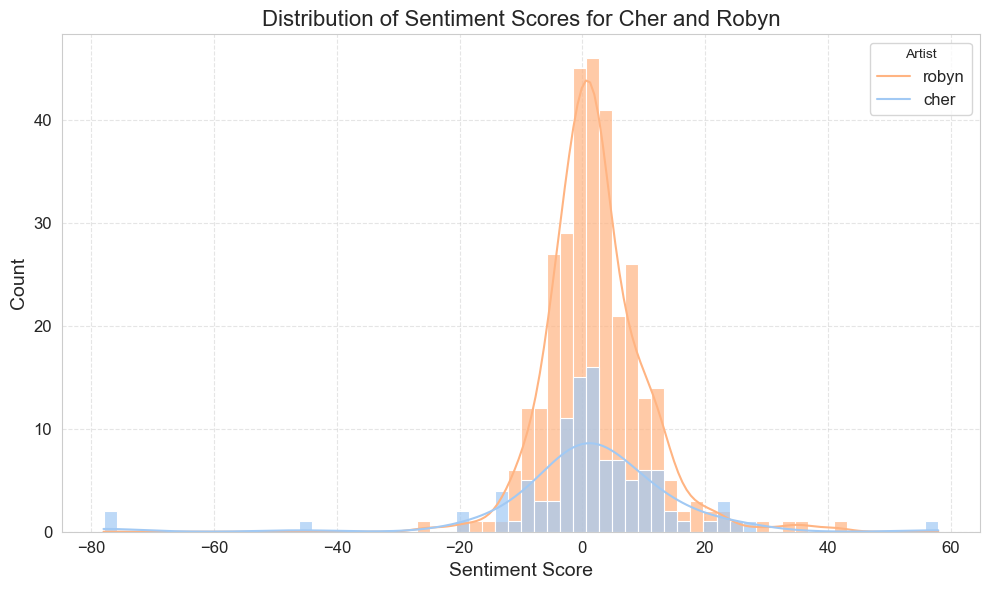

In [11]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(data=lyrics_data, x='SentimentScore', hue='artist', kde=True, palette='pastel', alpha=0.7)
plt.title('Distribution of Sentiment Scores for Cher and Robyn', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Artist', labels=lyrics_data['artist'].unique(), fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: <!-- Your answer here -->

cher has 2.18 sentiment score, and robyn has 0.88. so cher has higher average sentiment per song.


---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

cher:

highest: Perfection, Love And Understanding, and My Love.
lowest: I Walk On Guilded Splinters, Outrageous, and Julie.

The sentiment score is influenced by the lexicon utilized for sentiment analysis. Positive words contribute positively to the sentiment score (+1), while negative words contribute negatively (-1). In the provided lyrics of Cher, high sentiment score songs often include words associated with perfection, love, understanding, etc. Conversely, low sentiment score songs might include words associated with concepts like danger, which although negative, may not be as severe, thus resulting in an average sentiment score higher than Robyn's sentiment score.


A: <!-- Your answer here -->

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

robyn:

highest: Love Is Free, Indestructible, and Buffalo Stance.
lowest: Don't Fucking Tell Me What To Do, Don't Fucking Tell Me What To Do, and Criminal Intent.

In the provided robyn's lyrics, high sentiment score songs typically include words associated with love, free etc. Conversely, low sentiment score songs may contain words associated with concepts like criminal, killing, etc., which can be excessively violent and significantly lower the sentiment scores.

A: <!-- Your answer here -->

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [12]:
# your code here

positive_emojis = ["👍", "🥳", "🤩", "🙌", "😃", "😁", "😄", "😊", "🎉", "👏", "🥰"]
negative_emojis = ["😔", "😞", "👎", "🙁", "😡", "😠", "🤬", "😩", "🤯", "😤", "🙄"]

import pandas as pd

def read_sentiment_emojis(positive_emojis, negative_emojis):
    sentiment_emojis = []

    for emoji in positive_emojis:
        sentiment_emojis.append({'emoji': emoji, 'score': 1})

    for emoji in negative_emojis:
        sentiment_emojis.append({'emoji': emoji, 'score': -1})

    return pd.DataFrame(sentiment_emojis)

sentiment_emojis_df = read_sentiment_emojis(positive_emojis, negative_emojis)
sentiment_emojis_df

,emoji,score
0,👍,1
1,🥳,1
2,🤩,1
3,🙌,1
4,😃,1
5,😁,1
6,😄,1
7,😊,1
8,🎉,1
9,👏,1


In [13]:
def extract_emojis(text):
    emoji_pattern = re.compile("[" +
                               "".join(map(re.escape, positive_emojis + negative_emojis)) +
                               "]+", flags=re.UNICODE)
    emojis = emoji_pattern.findall(text)
    return emojis

# extract emojis from the 'description' column
twitter_data['emojis'] = twitter_data['description'].apply(extract_emojis)

twitter_data['emojis'] = twitter_data['emojis'].apply(list)

twitter_data

,artist,description,emojis
0,cher,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,[]
1,cher,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,[]
2,cher,csu,[]
3,cher,Writer @Washinformer @SpelmanCollege alumna #D...,[]
4,cher,I’m unemployed and live with my parents. MOOPS!,[]
...,...,...,...
2191118,robynkonichiwa,"singer of songs, type 1 diabetic, tired $jakel...",[]
2191119,robynkonichiwa,Dadx2/ Con-Arch/ Photographer/ DK #stemgrønnes...,[]
2191120,robynkonichiwa,A year to change a life is still a year ✨😌,[]
2191121,robynkonichiwa,Head of Consumer - Mango. Made in Melbourne. R...,[]


In [14]:
filtered_data = twitter_data[twitter_data['emojis'].apply(len) > 0]
filtered_data

,artist,description,emojis
114,cher,sub 2 bambinobecky ☺️🙌🏼👌🏼💯,[🙌]
177,cher,"Grandma, great grandma, Air Force veteran, ret...",[👎]
213,cher,Stand with Ukraine 🇺🇦 Dan’s wife 🥰 Mollie’s mo...,[🥰]
329,cher,Paget Brewster's wig 😍👍 she/her,[👍]
342,cher,👏🏻👏🏻👏🏻,"[👏, 👏, 👏]"
...,...,...,...
2190196,robynkonichiwa,You think you can insult me? I had a deadbeat ...,[🥰🥰]
2190429,robynkonichiwa,"Mom, Casting Director🎬, BC Survivor🎀. ♐that ke...",[😄]
2190522,robynkonichiwa,Nerd 🤓 Herzinfarkt survivor 🕺🏼#notjustsad 🌈 Le...,[🎉]
2190662,robynkonichiwa,"Lover of: Music,Horror and a tiny linebacker t...",[🥰]


In [15]:
filtered_data = twitter_data[twitter_data['emojis'].apply(len) > 0].copy()

# Initialize sentiment scores to 0
filtered_data['SentimentScore'] = 0

# Iterate over sentiment emojis and calculate scores
for emoji, score in sentiment_emojis_df[['emoji', 'score']].values:
    filtered_data['SentimentScore'] += filtered_data['emojis'].apply(lambda x: x.count(emoji) * score)

filtered_data

,artist,description,emojis,SentimentScore
114,cher,sub 2 bambinobecky ☺️🙌🏼👌🏼💯,[🙌],1
177,cher,"Grandma, great grandma, Air Force veteran, ret...",[👎],-1
213,cher,Stand with Ukraine 🇺🇦 Dan’s wife 🥰 Mollie’s mo...,[🥰],1
329,cher,Paget Brewster's wig 😍👍 she/her,[👍],1
342,cher,👏🏻👏🏻👏🏻,"[👏, 👏, 👏]",3
...,...,...,...,...
2190196,robynkonichiwa,You think you can insult me? I had a deadbeat ...,[🥰🥰],0
2190429,robynkonichiwa,"Mom, Casting Director🎬, BC Survivor🎀. ♐that ke...",[😄],1
2190522,robynkonichiwa,Nerd 🤓 Herzinfarkt survivor 🕺🏼#notjustsad 🌈 Le...,[🎉],1
2190662,robynkonichiwa,"Lover of: Music,Horror and a tiny linebacker t...",[🥰],1


In [16]:
filtered_data.groupby('artist')['SentimentScore'].mean()

artist
cher              0.762181
robynkonichiwa    0.802402
Name: SentimentScore, dtype: float64

In [17]:
cher_positive = filtered_data[(filtered_data['artist'] == 'cher') & (filtered_data['SentimentScore'] > 0)]
cher_negative = filtered_data[(filtered_data['artist'] == 'cher') & (filtered_data['SentimentScore'] < 0)]

In [18]:
print("Cher's most popular positive emojis:")
print(cher_positive['emojis'].value_counts().head(1))
print("Cher's most popular negative emojis:")
print(cher_negative['emojis'].value_counts().head(1))

Cher's most popular positive emojis:
emojis
[😊]    3576
Name: count, dtype: int64
Cher's most popular negative emojis:
emojis
[🙄]    666
Name: count, dtype: int64


In [19]:
robyn_positive = filtered_data[(filtered_data['artist'] == 'robynkonichiwa') & (filtered_data['SentimentScore'] > 0)]
robyn_negative = filtered_data[(filtered_data['artist'] == 'robynkonichiwa') & (filtered_data['SentimentScore'] < 0)]

In [20]:
print("Robyn's most popular positive emojis:")
print(robyn_positive['emojis'].value_counts().head(1))
print("Robyn's most popular negative emojis:")
print(robyn_negative['emojis'].value_counts().head(1))

Robyn's most popular positive emojis:
emojis
[😊]    138
Name: count, dtype: int64
Robyn's most popular negative emojis:
emojis
[🙄]    35
Name: count, dtype: int64


Q: What is the average sentiment of your two artists? 

A: <!-- Your answer here --> 

Cher's related tweets average sentiment score is: 0.72.
Robyn's related tweets average sentiment score is: 0.76.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: <!-- Your answer here --> 

For Cher's related tweets, the most popular positive emoji is 😊, and the most negative emoji is: 🙄.
For Robyn's related tweets, the most popular positive emoji is 😊, and the most negative emoji is: 🙄.
